Import packages

In [229]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv
from numpy import genfromtxt
from math import pi
plt.ion()
plt.rcParams.update({'font.size': 22,'legend.fontsize': 16})
dirname = '/home/msilvafe/Documents/SO/umux/Noise/'

Initialize Constants

In [230]:
k_b = 1.38e-23 #k Boltzmann [J/K]
phi_0 = 2.067833831e-15 #Flux Quantum in [Wb]
Ntones_MF = 1792.
Ntones_MF_db = 10*np.log10(Ntones_MF)
Ntones_HF = 1792.
Ntones_HF_db = 10*np.log10(Ntones_HF)
Ntones_LF = 1195.
Ntones_LF_db = 10*np.log10(Ntones_LF)
Ntones = 2000.
Ntones_db = 10*np.log10(Ntones)
N_MF = 12
N_HF = 6
N_LF = 3
Ntones_tot = N_MF*Ntones_MF+N_HF*Ntones_HF+N_LF*Ntones_LF
Ntones_tot_db = 10*np.log10(Ntones_tot)
Lambda = 0.333
dfdOhi0 = 2.17e5 # Hz/Phi_0
fmin = 4e9
fmax = 8e9
Q = 5e4
dfdI = 4.59e-2 # Hz/pA
LJ = 6.69e-11
#Inductance Matrix
Lsqsq = 2.23e-11
Lsqfr = 2.71e-11
Lsqin=2.28e-10
Lsqres=1.35e-12
Lfrfr=6.49e-10
Lfrin=3.96e-10
Lfrres=2.5e-12
Linin=5.48e-9
Linres=1.86e-11
Lresres=2.28e-10
Psmurfmax=0.
LNA_TN= [2.1,40.,191.]

Define Function for Reading In Coax Attenuation Data and Fit for slope and intercept

In [231]:
def readcoax(fname,f_eval):
    d = genfromtxt(fname, delimiter=',')
    slope_T1=(d[2,1]-d[1,1])/(d[2,0]-d[1,0])
    slope_T2=(d[2,2]-d[1,2])/(d[2,0]-d[1,0])
    int_T1=d[1,1]-slope_T1*d[1,0]
    int_T2=d[1,2]-slope_T2*d[1,0]
    dT1_feval=slope_T1*f_eval+int_T1
    dT2_feval=slope_T2*f_eval+int_T2
    slope = (dT1_feval-dT2_feval)/(d[0,1]-d[0,2])
    intercept = dT1_feval - slope*d[0,1]
    return [slope, intercept]

Read in config file for input coax chain

In [232]:
c = pd.read_csv(dirname+'InputChain.csv', delimiter=',')
d = np.transpose(c.values)
compin = d[0,:]
lossin = d[1,:]
Tavgin = (d[2,:]+d[3,:])/2
coax_YNin = d[4,:]
coax_typein = d[5,:]
coax_lin = d[6,:]
for i in range(len(compin)):
    if coax_YNin[i] == 'Y':
        t = readcoax(dirname+coax_typein[i]+'.csv',8)
        lossin[i] = (t[0]*Tavgin[i]+t[1])*coax_lin[i]

Read in config file for output coax chain

In [233]:
c = pd.read_csv(dirname+'OutputChain.csv',delimiter=',')
d = np.transpose(c.values)
compout = d[0,:]
lossout = d[1,:]
Tavgout = (d[2,:]+d[3,:])/2
coax_YNout = d[4,:]
coax_typeout = d[5,:]
coax_lout = d[6,:]
Gtot = 0.
for i in range(len(compout)):
    if coax_YNout[i] == 'Y':
        t = readcoax(dirname+coax_typeout[i]+'.csv',8)
        lossout[i] = (t[0]*Tavgout[i]+t[1])*coax_lout[i]

Define Function to refer noise temp through the chain

In [234]:
def ref_noise_temp(loss,temp,T0,p=False):
    T=T0
    loss_lin = 10.**(-loss/10.)
    for i in range(len(loss)):
        Tp = T*loss_lin[i] + temp[i]*(1-loss_lin[i])
        T=Tp
    if p==True:
        print(T0, 'K Noise Temp Referred to Feedline: ',T,' K')    
    return T

Calculate 300K referred

In [235]:
T_300K_Referred = ref_noise_temp(lossin,Tavgin,300.)
print('300K referred =', np.round(T_300K_Referred,2), 'K')

300K referred = 1.53 K


Define Function to Calculate the Power Referred to the Feedline

In [249]:
def p_referred_pertone(loss, Pin, p=False):
    Pout = Pin - sum(loss)
    if p==True:
        print('Power at Feedline: ',Pout,'dB')
    return Pout
#As an example we will print the power per tone at the feedline for 
#the maximum output of SMuRF 
Pmax=Psmurfmax-Ntones_db
Pfeedmax = p_referred_pertone(lossin,Pmax)
print('Maximum Power at Feedline Given SMuRF Limits = ',np.round(Pfeedmax,2),'dB')

Maximum Power at Feedline Given SMuRF Limits =  -65.22 dB


Define Function to Calculate Noise from DAC

In [244]:
def refer_phase_noise(dBc,loss,temp,Pin,k_b = k_b, Q = Q, f = fmax,dfdI = dfdI, p=False):
    T_out = (10.**((Pin-dBc)/10)*.001)/k_b
    T_feed = ref_noise_temp(loss,temp,T_out)
    P_feed = p_referred_pertone(loss,Pin)
    dBc_feed = 10*np.log10(k_b*T_feed/.001) - P_feed
    Sphi = 10**(dBc_feed/10)
    Sf = Sphi*(f/(2*Q))**2
    NEI = np.sqrt(Sf/(dfdI**2))
    if p == True:
        print('Phase Noise of: ',dBc, 'dBc/Hz referred to NEI:',NEI)
    return NEI

Define Function to Calculate the Noise Temperatures Referred to LNA-1 input (i.e. 300K noise referred to feed, LNA chain referred to LNA-1 input, pseudo noise referred to LNA-1 input, etc.)

In [245]:
def TN_to_NEI(T,LJ=LJ,f0=fmin,Min=Lsqin,phi_0=phi_0,alpha=1./2.,p=False):
    NEI = (1./np.sqrt(alpha))*np.sqrt((4.*k_b*T*LJ)/(pi*f0))*(1/Min)
    if p == True:
        print('Noise temp', T, 'K @ LNA-1 input referred to NEI:',np.round(NEI/1e-12,2),'pA/rt(Hz)')
    return NEI/1e-12

Define Function to Calculate the HEMT Pseudo Noise Floor from 3rd Order Nonlinearity

In [246]:
def Pseudo_Noise_Floor(Pin,loss,Dip,Ntones=Ntones,k_b=k_b):
    BWNL = 10*np.log10(12e9)
    NNLtones = 10*np.log10(Ntones*(Ntones-2))
    P_LNA1 = p_referred_pertone(loss,Pin)-Dip
    P_perspur_out = 3.*P_LNA1+100. #This comes from IP3 Measurements
    P_NL_out = P_perspur_out+NNLtones
    PNP_out = P_NL_out-BWNL
    PNP_in = PNP_out - 39 
    #This comes from the Gain of the 2 stage amplifiers shouldn't hard code this in the long run
    PNP_K = (10.**(PNP_in/10.)*.001)/k_b
    PNP_NEI = TN_to_NEI(PNP_K)
    return(PNP_NEI)

Define Function to Calculate the Referred HEMT Noise

In [247]:
def Total_Chain_Noise(loss_out,LNA_TN=LNA_TN):
    TNtot = 0.
    Gaintot_lin = 10**(np.sum((-loss_out))/10.)
    j=0
    loss_lin = 10.**(-loss_out/10.)
    for i in range(len(loss_out)):
        if loss_out[i]>0:
            TNtot = TNtot*loss_lin[i] + Tavgout[i]*(1.-loss_lin[i])
        if loss_out[i]<0:
            TNtot = (TNtot+LNA_TN[j])*loss_lin[i]
            j=j+1;
    TNout = TNtot/Gaintot_lin
    return TNout

In [248]:
Total_Chain_Noise(lossout)

3.3638684980029736

Define Function to add noise in quadrature

In [215]:
def quad_sum(a,b):
    out=np.sqrt(a**2+b**2)
    return out

Define Function to Sum All Noise Sources

In [222]:
def Calc_All_Noise(lossin = lossin, Tavgin = Tavgin, loss_out = lossout,Pin=-38.,LNA_TN=LNA_TN, p=False):
    N_PNP = Pseudo_Noise_Floor(Pin,lossin,10)
    N_DAC = refer_phase_noise(101,lossin,Tavgin,Pin)
    N_300K = TN_to_NEI(ref_noise_temp(lossin,Tavgin,300.))
    N_HEMT_TN = TN_to_NEI(Total_Chain_Noise(lossout,LNA_TN=LNA_TN))
    N_TES_bias = 0. #This number is just by design
    NEI_tot = quad_sum(quad_sum(quad_sum(N_PNP,N_DAC),quad_sum(N_300K,N_HEMT_TN)),N_TES_bias)
    if p==True:
        print(N_PNP,N_DAC,N_300K,N_HEMT_TN)
    return NEI_tot

In [217]:
Calc_All_Noise()

17.131029432536295

Now we have the framework to iterate through attenuators and look at the impact on total noise

In [138]:
from random import randint

AttenRand = np.zeros((4,100000))
NoiseTot = np.zeros(100000)
for i in range(np.shape(AttenRand)[1]):
    Max0 = 6+6+3+1
    Max = Max0
    tot=0
    for j in range(4):
        #print(j,Max)
        AttenRand[j,i] = randint(0,Max)
        Max = Max-AttenRand[j,i]
        if j == 0:
            lossin[3]=AttenRand[j,i]
            #print(j,lossin[3])
        if j == 1:
            lossin[6]=AttenRand[j,i]   
            #print(j,lossin[6])            
        if j ==2:
            lossin[14]=AttenRand[j,i]
            #print(j,lossin[14])            
        if j == 3:     
            lossin[17]=Max0-tot
            #print(j,lossin[17])
        tot=tot+AttenRand[j,i]

    NoiseTot[i]=Calc_All_Noise(lossin=lossin)

Text(0, 0.5, 'Noise [pA/rt(Hz)]')

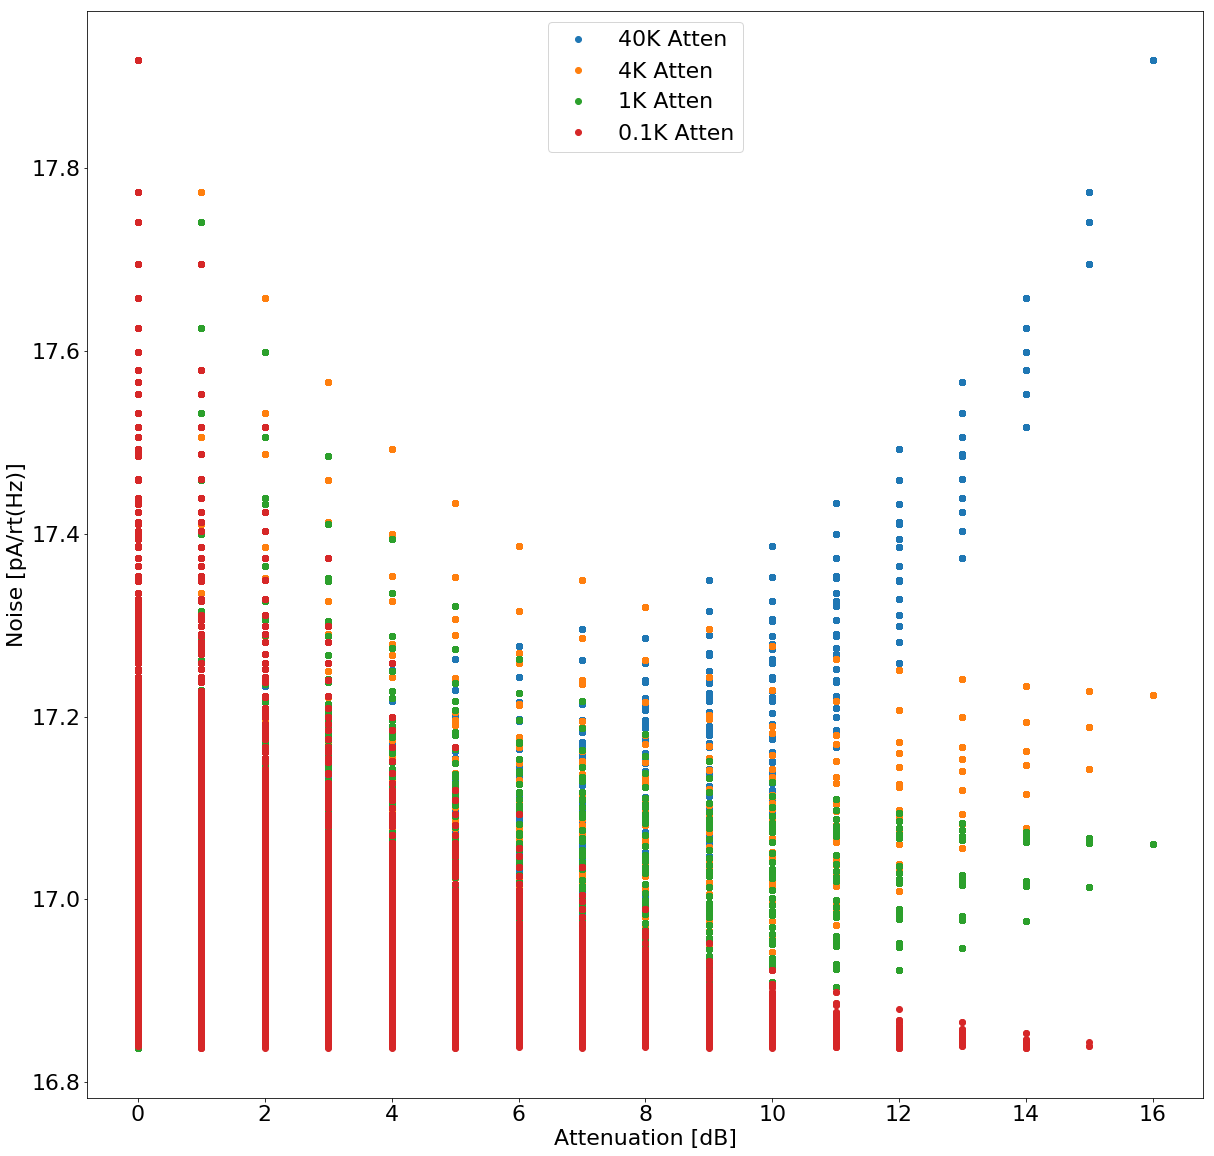

In [139]:
plt.figure(figsize=(20,20))
plt.plot(AttenRand[0,:], NoiseTot,'o',label='40K Atten');
'''plt.legend()
plt.xlabel('Attenuation [dB]')
plt.ylabel('Noise [pA/rt(Hz)]')
plt.figure(figsize=(20,20))'''
plt.plot(AttenRand[1,:], NoiseTot,'o',label='4K Atten');
'''plt.legend()
plt.xlabel('Attenuation [dB]')
plt.ylabel('Noise [pA/rt(Hz)]')
plt.figure(figsize=(20,20))'''
plt.plot(AttenRand[2,:], NoiseTot,'o',label='1K Atten');
'''plt.legend()
plt.xlabel('Attenuation [dB]')
plt.ylabel('Noise [pA/rt(Hz)]')
plt.figure(figsize=(20,20))'''
plt.plot(AttenRand[3,:], NoiseTot,'o',label='0.1K Atten');
plt.legend()
plt.xlabel('Attenuation [dB]')
plt.ylabel('Noise [pA/rt(Hz)]')

Now let's assume all of the attenuation is at 40K or at 0.1K and then vary the total attenuation and look at what that looks like total noise vs total attenuation.

Text(0, 0.5, 'Total Noise[pA/rt(Hz)]')

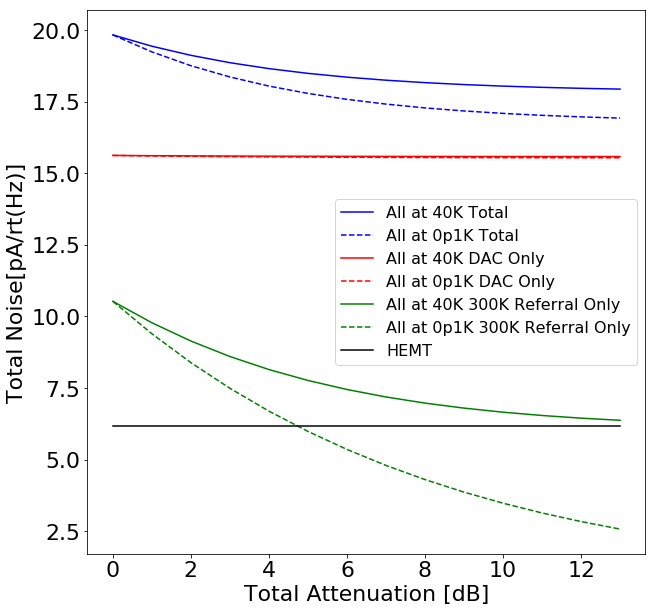

In [178]:
AttenTot = np.arange(0,14,1)
Allat40 = np.zeros(len(AttenTot))
Allat0p1 = np.zeros(len(AttenTot))
Allat40_DAC = np.zeros(len(AttenTot))
Allat0p1_DAC = np.zeros(len(AttenTot))
Allat40_300K = np.zeros(len(AttenTot))
Allat0p1_300K = np.zeros(len(AttenTot))
HEMT = np.zeros(len(AttenTot))
lossin[6]=0.
lossin[14]=0.
i=0
for Atten in AttenTot:
    lossin[3]=Atten
    lossin[17]=0.
    Allat40[i]=Calc_All_Noise(lossin=lossin,Pin=-51+Atten)#,p=True)
    Allat40_DAC[i] = refer_phase_noise(101,lossin,Tavgin,Pin=-51+Atten)
    Allat40_300K[i] = TN_to_NEI(ref_noise_temp(lossin,Tavgin,300.))
    lossin[3]=0
    lossin[17]=Atten
    Allat0p1[i]=Calc_All_Noise(lossin=lossin,Pin=-51+Atten)#,p=True)
    Allat0p1_DAC[i] = refer_phase_noise(101,lossin,Tavgin,Pin=-51+Atten)
    Allat0p1_300K[i] = TN_to_NEI(ref_noise_temp(lossin,Tavgin,300.))
    HEMT[i] = TN_to_NEI(Total_Chain_Noise(lossout))
    i=i+1
plt.figure(figsize=(10,10))
plt.plot(AttenTot,Allat40,'b-',label='All at 40K Total')
plt.plot(AttenTot,Allat0p1,'b--',label='All at 0p1K Total')
plt.plot(AttenTot,Allat40_DAC,'r-',label='All at 40K DAC Only')
plt.plot(AttenTot,Allat0p1_DAC,'r--',label='All at 0p1K DAC Only')
plt.plot(AttenTot,Allat40_300K,'g-',label='All at 40K 300K Referral Only')
plt.plot(AttenTot,Allat0p1_300K,'g--',label='All at 0p1K 300K Referral Only')
plt.plot(AttenTot,HEMT,'k-',label='HEMT')
plt.legend()
plt.xlabel('Total Attenuation [dB]')
plt.ylabel('Total Noise[pA/rt(Hz)]')

Now let's explore how some of the noise sources depend on our resonator parameters

First let's look at the Pseudo Noise Floor as a function of Dip Depth

In [252]:
dip_depth = np.arange(1,21,1)
noise1 = np.zeros(len(dip_depth))
noise2 = np.zeros(len(dip_depth))
noise3 = np.zeros(len(dip_depth))
noise4 = np.zeros(len(dip_depth))
noise5 = np.zeros(len(dip_depth))
noise6 = np.zeros(len(dip_depth))
i=0
for dip in dip_depth:
    noise1[i] = Pseudo_Noise_Floor(Pin=Pmax,loss=lossin,Dip=dip)
    noise2[i] = Pseudo_Noise_Floor(Pin=Pmax-1.,loss=lossin,Dip=dip)
    noise3[i] = Pseudo_Noise_Floor(Pin=Pmax-2.,loss=lossin,Dip=dip)
    noise4[i] = Pseudo_Noise_Floor(Pin=Pmax-3.,loss=lossin,Dip=dip)
    noise5[i] = Pseudo_Noise_Floor(Pin=Pmax-4.,loss=lossin,Dip=dip)
    noise6[i] = Pseudo_Noise_Floor(Pin=Pmax-5.,loss=lossin,Dip=dip)
    i=i+1   
p1 = p_referred_pertone(loss=lossin, Pin=Pmax, p=True)
p2 = p_referred_pertone(loss=lossin, Pin=Pmax-1, p=True)
p3 = p_referred_pertone(loss=lossin, Pin=Pmax-2, p=True)
p4 = p_referred_pertone(loss=lossin, Pin=Pmax-3, p=True)
p5 = p_referred_pertone(loss=lossin, Pin=Pmax-4, p=True)
p6 = p_referred_pertone(loss=lossin, Pin=Pmax-5, p=True)

Power at Feedline:  -65.21808275290692 dB
Power at Feedline:  -66.21808275290692 dB
Power at Feedline:  -67.21808275290692 dB
Power at Feedline:  -68.21808275290692 dB
Power at Feedline:  -69.21808275290692 dB
Power at Feedline:  -70.21808275290692 dB


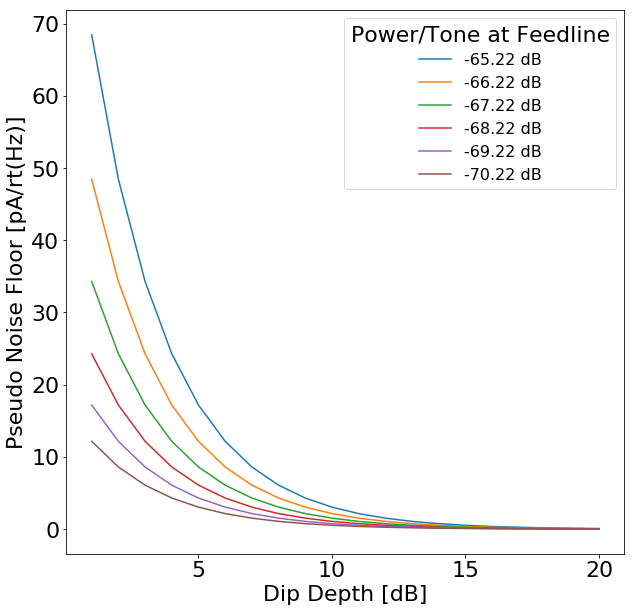

In [253]:
plt.figure(figsize=(10,10))
plt.plot(dip_depth,noise1,label = str(np.round(p1,2))+' dB')
plt.plot(dip_depth,noise2,label = str(np.round(p2,2))+' dB')
plt.plot(dip_depth,noise3,label = str(np.round(p3,2))+' dB')
plt.plot(dip_depth,noise4,label = str(np.round(p4,2))+' dB')
plt.plot(dip_depth,noise5,label = str(np.round(p5,2))+' dB')
plt.plot(dip_depth,noise6,label = str(np.round(p6,2))+' dB')
plt.xlabel('Dip Depth [dB]')
plt.ylabel('Pseudo Noise Floor [pA/rt(Hz)]')
plt.legend(title = 'Power/Tone at Feedline')

Now let's look at the phase noise dependence on df/dI and on Q

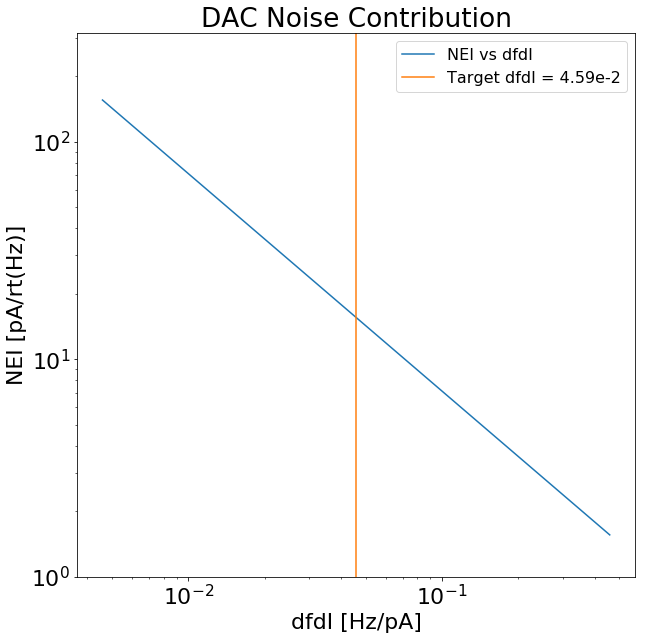

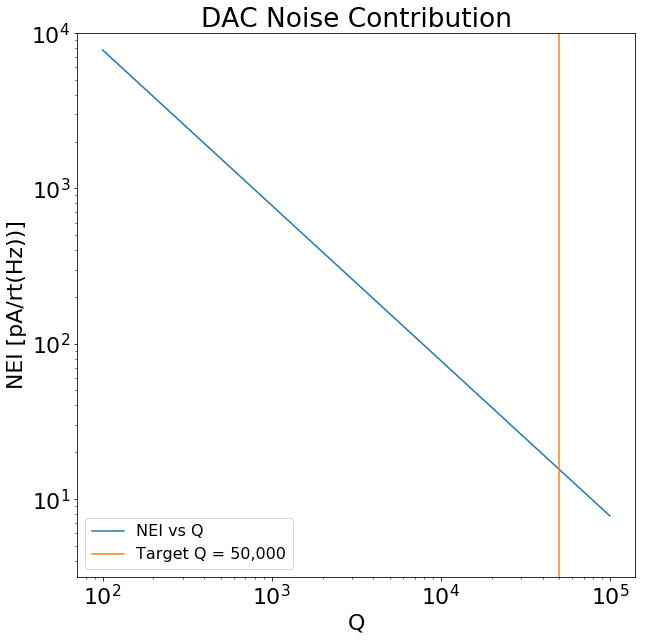

In [196]:
dfdI_vary = np.logspace(np.log10(0.1*dfdI),np.log10(10*dfdI),100)
Q_vary = np.logspace(2,5,100)
DAC_varydfdI = np.zeros(len(dfdI_vary))
DAC_varyQ = np.zeros(len(Q_vary))
i=0
for dfdI_v in dfdI_vary:
    DAC_varydfdI[i] = refer_phase_noise(dBc=101,loss=lossin,temp=Tavgin,Pin=-38,k_b = k_b, Q = Q, f = fmax,dfdI = dfdI_v,p=False)
    i=i+1
i=0
for Q_v in Q_vary:
    DAC_varyQ[i] = refer_phase_noise(dBc=101,loss=lossin,temp=Tavgin,Pin=-38,k_b = k_b, Q = Q_v, f = fmax,dfdI = dfdI,p=False)
    i=i+1
plt.figure(figsize=(10,10))
plt.loglog(dfdI_vary,DAC_varydfdI,label = 'NEI vs dfdI')
plt.loglog([dfdI,dfdI],[0,10**3],label = 'Target dfdI = 4.59e-2')
plt.ylim([10**0,10**2.5])
plt.xlabel('dfdI [Hz/pA]')
plt.ylabel('NEI [pA/rt(Hz)]')
plt.title('DAC Noise Contribution')
plt.legend()
plt.figure(figsize=(10,10))
plt.loglog(Q_vary,DAC_varyQ,label='NEI vs Q')
plt.loglog([Q,Q],[0,10**4],label='Target Q = 50,000')
plt.ylim([10**0.5,10**4])
plt.xlabel('Q')
plt.ylabel('NEI [pA/rt(Hz))]')
plt.title('DAC Noise Contribution')
plt.legend()

Let's now vary the LNA-1 input noise temp to look at when the HEMT noise dominates the other noise sources

Text(0, 0.5, 'Total Noise[pA/rt(Hz)]')

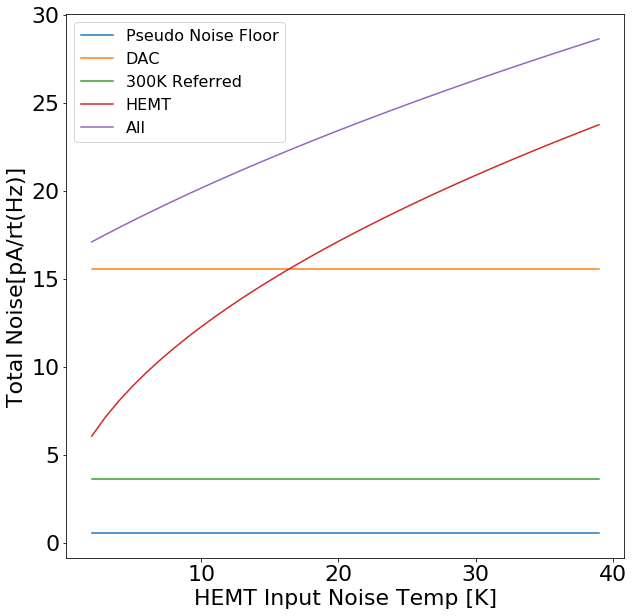

In [223]:
TNvary = np.arange(2.0,40.,1)
HEMT_TNvary = np.zeros(len(TNvary))
N_PNP = np.zeros(len(TNvary))
N_DAC = np.zeros(len(TNvary))
N_300K = np.zeros(len(TNvary))
All = np.zeros(len(TNvary))
i=0
for TN in TNvary:
    LNA_TN[0]=TN
    N_PNP[i] = Pseudo_Noise_Floor(-35,lossin,10)
    N_DAC[i] = refer_phase_noise(101,lossin,Tavgin,Pin=-35)
    N_300K[i] = TN_to_NEI(ref_noise_temp(lossin,Tavgin,300.))
    HEMT_TNvary[i] = TN_to_NEI(Total_Chain_Noise(lossout,LNA_TN=LNA_TN))
    All[i]=Calc_All_Noise(Pin=-35,LNA_TN=LNA_TN)
    i=i+1
plt.figure(figsize=(10,10))
plt.plot(TNvary,N_PNP,label='Pseudo Noise Floor')
plt.plot(TNvary,N_DAC,label='DAC')
plt.plot(TNvary,N_300K,label='300K Referred')
plt.plot(TNvary,HEMT_TNvary,label='HEMT')
plt.plot(TNvary,All,label='All')
plt.legend()
plt.xlabel('HEMT Input Noise Temp [K]')
plt.ylabel('Total Noise[pA/rt(Hz)]')